Using device: cpu
Epoch 0 | Loss: 3.002974e+03
Epoch 500 | Loss: 6.441296e+02
Epoch 1000 | Loss: 1.219175e+02
Epoch 1500 | Loss: 2.596283e+01
Epoch 2000 | Loss: 1.716934e+01
Epoch 2500 | Loss: 9.643663e-01
Epoch 3000 | Loss: 3.544906e-01
Epoch 3500 | Loss: 1.620096e-01
Epoch 4000 | Loss: 8.912107e-02
Epoch 4500 | Loss: 7.714406e-02
Training complete.


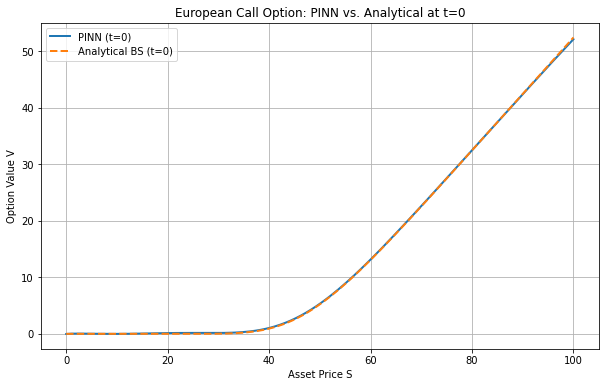

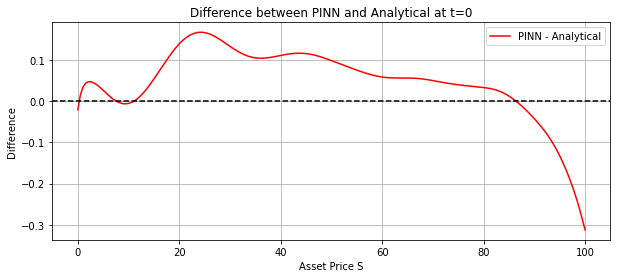

MSE between PINN and Analytical at t=0: 9.7337e-03


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title: Black–Scholes PDE for a European Call using PINNs (Comparison to Analytical)

We solve the PDE:
    V_t + 0.5*sigma^2 * S^2 * V_SS + r*S*V_S - r*V = 0
with
    Terminal condition at t=T: V(S,T) = max(S-K, 0),
    Boundary conditions:
        V(0,t) = 0
        V(Smax,t) = Smax - K*exp(-r*(T-t))

We'll train a neural network V_theta(S,t) by enforcing:
    - PDE residual in the interior of (S in [0,Smax], t in [0,T])
    - Boundary condition losses
    - Terminal condition loss

After training, we compare at t=0 vs. the closed-form Black–Scholes
price for a European call option.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --------------------- Black–Scholes Parameters ---------------------
r = 0.05        # risk-free rate
sigma = 0.2     # volatility
K = 50.0        # strike
T = 1.0         # maturity
S_max = 100.0   # max price

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------- Neural Network Definition ---------------------
class BSNet(nn.Module):
    """
    Neural network for V(S,t).
    Input = (S,t), output = V(S,t).
    We'll use 3 hidden layers with Tanh activation.
    """
    def __init__(self, hidden_units=50):
        super(BSNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.layers(x)

# --------------------- PDE Residual Function ---------------------
def bs_residual(model, S, t):
    """
    Compute PDE residual:
        V_t + 0.5*sigma^2*S^2*V_SS + r*S*V_S - r*V = 0
    """
    # enable grads
    S.requires_grad_(True)
    t.requires_grad_(True)

    X = torch.cat([S, t], dim=1)  # shape (N,2)
    V = model(X)                  # shape (N,1)

    # Partial derivatives via autograd
    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V),
                              create_graph=True)[0]
    V_S = torch.autograd.grad(V, S, grad_outputs=torch.ones_like(V),
                              create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S),
                               create_graph=True)[0]

    residual = V_t + 0.5*sigma**2 * S**2 * V_SS + r*S*V_S - r*V
    return residual

# --------------------- Sampler ---------------------
def sampler(N_int, N_bc, N_term):
    """
    Return:
       - interior collocation points (S in [0,Smax], t in [0,T])
       - boundary points for S=0, S=Smax
       - terminal points for t=T
    """
    # interior
    S_int = torch.rand(N_int,1, device=device)*S_max
    t_int = torch.rand(N_int,1, device=device)*T

    # boundary S=0
    S_bc0 = torch.zeros(N_bc,1, device=device)
    t_bc0 = torch.rand(N_bc,1, device=device)*T

    # boundary S=Smax
    S_bc1 = torch.ones(N_bc,1, device=device)*S_max
    t_bc1 = torch.rand(N_bc,1, device=device)*T

    # terminal t=T
    S_term = torch.rand(N_term,1, device=device)*S_max
    t_term = torch.ones(N_term,1, device=device)*T

    return (S_int, t_int), (S_bc0, t_bc0), (S_bc1, t_bc1), (S_term, t_term)

# --------------------- Analytical Black–Scholes for a Call ---------------------
def black_scholes_call(S, K, T, r, sigma):
    """
    Closed-form solution for a European call option at t=0.
    S : asset prices (numpy array)
    K : strike
    T : time to maturity
    r : risk-free rate
    sigma : volatility
    """
    S = np.maximum(S, 1e-12)  # avoid log(0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return call

# --------------------- Main ---------------------
def main():
    model = BSNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 5000

    # --------------------- Training Loop ---------------------
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Sample points
        (S_int, t_int), (S_bc0, t_bc0), (S_bc1, t_bc1), (S_term, t_term) = sampler(2000, 200, 200)

        # PDE residual in interior
        r_int = bs_residual(model, S_int, t_int)
        loss_pde = torch.mean(r_int**2)

        # BC: V(0,t)=0
        X_bc0 = torch.cat([S_bc0, t_bc0], dim=1)
        V_bc0 = model(X_bc0)
        loss_bc0 = torch.mean(V_bc0**2)

        # BC: V(S_max,t) = S_max - K*exp(-r*(T-t))
        X_bc1 = torch.cat([S_bc1, t_bc1], dim=1)
        V_bc1 = model(X_bc1)
        bc1_target = S_max - K*torch.exp(-r*(T - t_bc1))
        loss_bc1 = torch.mean((V_bc1 - bc1_target)**2)

        # Terminal condition: V(S,T)=max(S-K,0)
        X_term = torch.cat([S_term, t_term], dim=1)
        V_term = model(X_term)
        term_target = torch.maximum(S_term - K, torch.zeros_like(S_term))
        loss_term = torch.mean((V_term - term_target)**2)

        # total loss
        loss = loss_pde + loss_bc0 + loss_bc1 + loss_term
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6e}")

    print("Training complete.")

    # --------------------- Evaluation: Compare at t=0 ---------------------
    # We'll evaluate the network at t=0 for a range of S in [0, S_max].
    S_vals = np.linspace(0, S_max, 200)
    t_zero = np.zeros_like(S_vals)
    S_tensor = torch.tensor(S_vals, dtype=torch.float32, device=device).unsqueeze(1)
    t_tensor = torch.tensor(t_zero, dtype=torch.float32, device=device).unsqueeze(1)

    model.eval()
    with torch.no_grad():
        X_eval = torch.cat([S_tensor, t_tensor], dim=1)
        V_pinn = model(X_eval).cpu().numpy().flatten()

    # Analytical Black–Scholes solution at t=0, T=1
    V_bs = black_scholes_call(S_vals, K, T, r, sigma)

    # --------------------- Plots ---------------------
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    plt.plot(S_vals, V_pinn, label='PINN (t=0)', linewidth=2)
    plt.plot(S_vals, V_bs, '--', label='Analytical BS (t=0)', linewidth=2)
    plt.xlabel('Asset Price S')
    plt.ylabel('Option Value V')
    plt.title('European Call Option: PINN vs. Analytical at t=0')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Difference plot
    diff = V_pinn - V_bs
    plt.figure(figsize=(10,4))
    plt.plot(S_vals, diff, color='r', label='PINN - Analytical')
    plt.axhline(0.0, color='k', linestyle='--')
    plt.xlabel('Asset Price S')
    plt.ylabel('Difference')
    plt.title('Difference between PINN and Analytical at t=0')
    plt.legend()
    plt.grid(True)
    plt.show()

    # MSE between PINN and analytical
    mse_value = np.mean(diff**2)
    print(f"MSE between PINN and Analytical at t=0: {mse_value:.4e}")

if __name__ == "__main__":
    main()
